# Feature Governance - Personal Data

BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives
In this notebook, we focus strictly on the "Who" variables—the borrower's identity, location, and stability. This is where we handle the sensitive regulatory topics (Fair Lending/ECOA) and Data Privacy (PII).

#### Step 1: Setup & Load Data
Start by loading the "Cleaned Base" we saved in the previous notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set global style
sns.set_style("whitegrid")

# Load the cleaned dataset (Status = 0 or 1 only)
df = pd.read_pickle('../../data/interim/loans_cleaned_base.pkl')

# Define the "Batch 1" columns we are auditing
personal_cols = [
    'emp_title', 'emp_length', 
    'home_ownership', 
    'zip_code', 'addr_state', 
    'application_type'
]

print(f"Analyzing {len(personal_cols)} personal features...")
display(df[personal_cols].head())

Analyzing 6 personal features...


,emp_title,emp_length,home_ownership,zip_code,addr_state,application_type
0,NaN,10+ years,RENT,860xx,AZ,Individual
1,Ryder,< 1 year,RENT,309xx,GA,Individual
2,NaN,10+ years,RENT,606xx,IL,Individual
3,AIR RESOURCES BOARD,10+ years,RENT,917xx,CA,Individual
4,University Medical Group,1 year,RENT,972xx,OR,Individual


#### Step 2: The "Bad Rate" Analysis
In Credit Risk, we don't just look at bar charts of counts. We look at Bad Rates (Default Rates) per category.

- If Renters have a 20% default rate and Homeowners have a 5% default rate, the variable is predictive.

- If both have 15%, the variable is useless.

In [ ]:
def plot_bad_rate(df: pd.DataFrame, feature: str, target: str = 'target', min_samples: int = 100) -> None:
    """
    Calculates and plots the Bad Rate (Default Rate) for a categorical feature.
    
    This function groups the data by the specified feature, calculates the 
    percentage of defaults (Target=1), and visualizes the relationship 
    using a dual-axis plot (Volume vs. Risk).

    Args:
        df (pd.DataFrame): The training dataset containing the feature and target.
        feature (str): The column name of the categorical variable to analyze.
        target (str, optional): The name of the binary target column (0=Good, 1=Bad). 
                                Defaults to 'target'.
        min_samples (int, optional): Minimum number of samples required to include 
                                     a category in the plot (filters noise). Defaults to 100.

    Returns:
        None: Displays a matplotlib figure directly.

    Raises:
        None
    """
    # Check if feature exists
    if feature not in df.columns:
        print(f"Skipping {feature}: Column not found in DataFrame.")
        return

    # Aggregate data
    group = df.groupby(feature).agg(
        total=(target, 'count'),
        bad=(target, 'sum')
    ).reset_index()
    
    # Calculate Bad Rate
    group['bad_rate'] = group['bad'] / group['total']
    
    # Filter for statistical significance
    group = group[group['total'] > min_samples]
    
    # Sort by Bad Rate for clearer visualization
    group = group.sort_values('bad_rate', ascending=False)
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # Bar Chart (Volume)
    sns.barplot(x=feature, y='total', data=group, color='lightgrey', alpha=0.6, ax=ax1)
    ax1.set_ylabel('Total Loan Volume', fontweight='bold')
    ax1.set_xlabel(feature, fontweight='bold')
    
    # Line Chart (Risk)
    ax2 = ax1.twinx()
    sns.lineplot(x=feature, y='bad_rate', data=group, marker='o', color='crimson', lw=2, ax=ax2)
    ax2.set_ylabel('Bad Rate (Default Probability)', color='crimson', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Formatting
    plt.title(f'Risk Analysis: {feature} (Volume vs Bad Rate)', fontsize=14)
    
    # Rotate x-labels if there are many categories
    if len(group) > 8:
        ax1.tick_params(axis='x', rotation=45)
        
    plt.show()

#### 3. Feature Analysis & Decisions
We iterate through the specific "Personal" variables.

#### A. Home Ownership (Capital Proxy)
Governance Context: This is a proxy for financial resilience. Borrowers who own assets (MORTGAGE/OWN) typically have lower default rates than RENT.
- Observation: You will likely see RENT has a higher bad rate. NONE, ANY, or OTHER are noisy buckets with low volume.

- Decision: Keep, but consolidate rare categories.

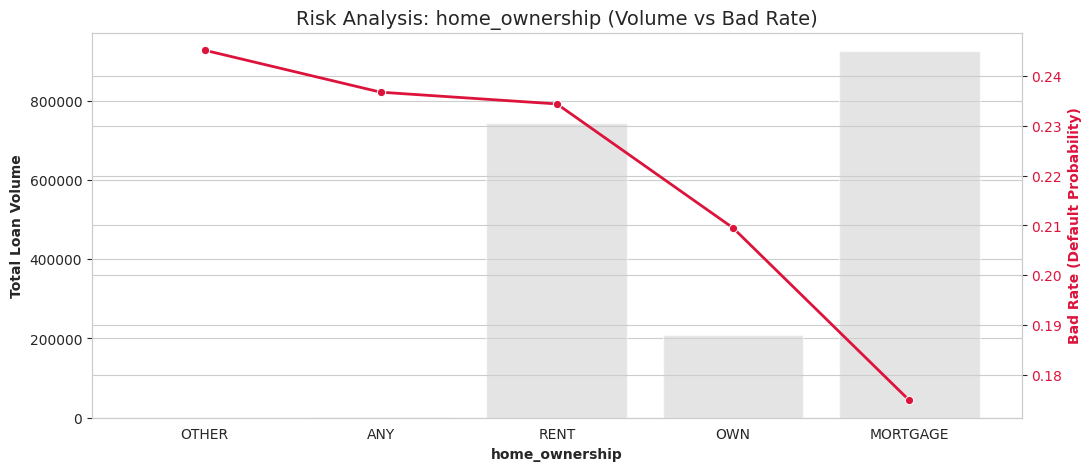

In [3]:
# Visualize raw relationship
plot_bad_rate(df, 'home_ownership')

#### B. Employment Length (Stability Proxy)
Governance Context: While often predictive, this field is "messy" (strings like "10+ years" vs "< 1 year").
- Observation: The curve usually slopes downward (longer employment = lower risk), validating the "Stability" hypothesis.

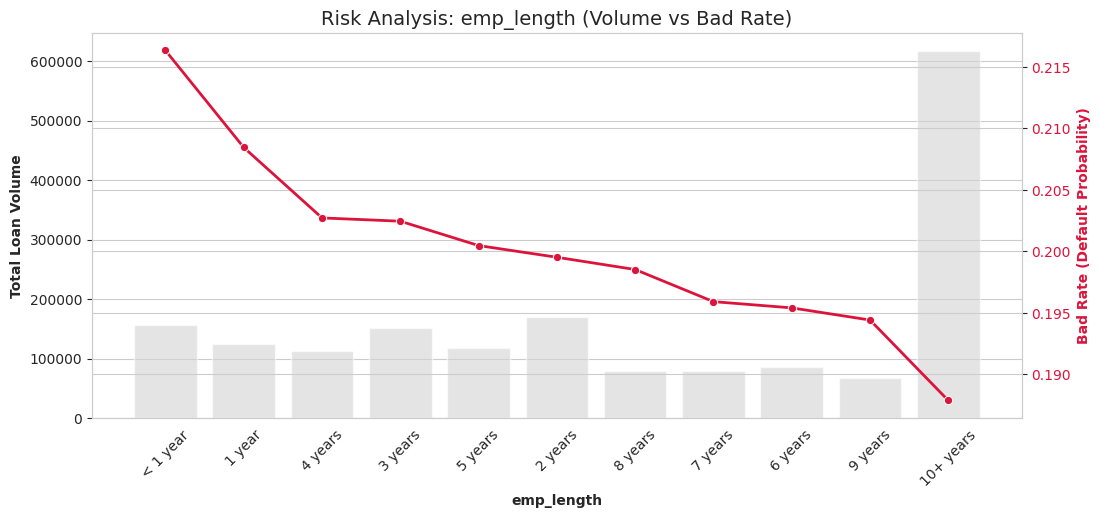

In [4]:
# Visualize raw relationship
plot_bad_rate(df, 'emp_length')

#### 4. Transformation Logic
We encapsulate the cleaning logic into a single, well-documented function to ensure reproducibility.

In [5]:
def clean_personal_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Applies governance transformations to personal/demographic features.
    
    Operations:
    1. emp_length: Converts string labels (e.g., '10+ years') to numeric (0-10).
       NaNs are filled with -1 to preserve 'informative missingness'.
    2. home_ownership: Consolidates rare classes ('NONE', 'ANY') into 'OTHER'.
    3. Drops PII and high-cardinality columns (zip_code, emp_title, etc.).

    Args:
        df_in (pd.DataFrame): The raw dataframe containing personal columns.

    Returns:
        pd.DataFrame: A copy of the dataframe with cleaned features and 
                      dropped columns.

    Raises:
        None
    """
    df_out = df_in.copy()
    
    # --- 1. Clean Employment Length ---
    # Map dictionary for direct string-to-int conversion
    emp_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, 
        '10+ years': 10
    }
    # Map and fill missing values with -1 (distinct category)
    df_out['emp_length_clean'] = df_out['emp_length'].map(emp_map).fillna(-1)
    
    # --- 2. Clean Home Ownership ---
    # Consolidate noise buckets
    if 'home_ownership' in df_out.columns:
        df_out['home_ownership_clean'] = df_out['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

    # --- 3. Drop Rejected Columns ---
    # zip_code: Redlining/Ethical risk (proxy for race).
    # emp_title: High Cardinality (too many unique values, e.g., "Accountant II").
    # member_id/id: PII (Personally Identifiable Information).
    # title/desc: Free text fields (require NLP, out of scope for standard scorecard).
    drop_cols = [
        'zip_code', 'emp_title', 'emp_length', 'home_ownership', 
        'id', 'member_id', 'url', 'desc', 'title'
    ]
    
    # Only drop columns that actually exist in the dataframe
    cols_to_drop = [c for c in drop_cols if c in df_out.columns]
    df_out.drop(columns=cols_to_drop, inplace=True)
    
    return df_out

# Apply the cleaning
df_clean = clean_personal_features(df)

print("Batch 1 Cleaning Complete.")
print(f"Columns remaining: {len(df_clean.columns)}")
display(df_clean[['home_ownership_clean', 'emp_length_clean', 'target']].head())

Batch 1 Cleaning Complete.
Columns remaining: 138


,home_ownership_clean,emp_length_clean,target
0,RENT,10.0,0
1,RENT,0.0,1
2,RENT,10.0,0
3,RENT,10.0,0
4,RENT,1.0,0


In [7]:
df_clean.to_pickle('../../data/interim/loans_batch1.pkl')
print("Base modeling data saved.")

Base modeling data saved.
